_____
# Advanced Data Visualization
## Cohort Visualization

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from operator import attrgetter


## 1. Import Data

In [2]:
df = pd.read_csv(r'C:\Users\user\Documents\Data Science\online_retail.csv', 
                 dtype={'CustomerID': str,
                        'InvoiceID': str},
                parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom


## 2. Cohort Analysis: Data Processing   

Transform to new DF:   
1. Cohort Date : tanggal pertama konsumen beraktivitas (ex: first transaction date)
2. Current Activity Date : waktu aktivitas berulang dari user (ex: second transaction date)
3. Total Distinct Subject : jumlah konsumen unique yg dikelompokan (ex:total new customer)
4. Period Distance : Rentang cohort date dan current activity date (lowest is 0 dan selalu positive number)

Base Cohort Tab;e Steps:
1. Cohort Date: Cari tahu first activity dari tiap user
2. Current Activity Date: Cari tahu current activity dari tiap user
3. Aggregate Distinct Total Users by Cohort Date and Current Activity Date
4. Buat period column dgn : Current Activity - Cohort Date
5. Buat pivot table dgn index = Cohort Date, column = Period, and Value = Total Distinct User

In [4]:
# 1. Create Cohort Monthly Based by finding Min date of invoice 
df['cohort_month'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# 2. Create Current Activity Date 
df['current_order_month'] = df['InvoiceDate'].dt.to_period('M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cohort_month,current_order_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,2010-01,2010-01
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01,2010-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,2010-01,2010-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01,2010-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01,2010-01


In [8]:
# 3. Find out Total Distinct User, based on cohort_month and current_order_month
df_cohort = df.groupby(['cohort_month', 'current_order_month']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)

df_cohort.head()

,cohort_month,current_order_month,n_customers
0,2010-01,2010-01,98
1,2010-01,2010-02,9
2,2010-01,2010-03,4
3,2010-01,2010-05,7
4,2010-01,2010-06,7


In [9]:
# 4. Find out Period Distance: current_order_month - cohort_month
df_cohort['period_number'] = (df_cohort['current_order_month'] - df_cohort['cohort_month']).apply(attrgetter('n'))

df_cohort.head()

,cohort_month,current_order_month,n_customers,period_number
0,2010-01,2010-01,98,0
1,2010-01,2010-02,9,1
2,2010-01,2010-03,4,2
3,2010-01,2010-05,7,4
4,2010-01,2010-06,7,5


In [10]:
# 5. Create pivot table: index=cohort_month, columns=period, value=n_customers
cohort_retention_pivot = df_cohort.pivot_table(index='cohort_month',
                                              columns='period_number',
                                              values='n_customers')
cohort_retention_pivot


period_number,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort_month,,,,,,,,,,,,,,,,,,,,,
2010-01,98.0,9.0,4.0,NaN,7.0,7.0,4.0,10.0,10.0,5.0,...,38.0,40.0,36.0,44.0,41.0,37.0,41.0,44.0,40.0,23.0
2010-02,108.0,2.0,NaN,NaN,3.0,7.0,5.0,12.0,5.0,NaN,...,39.0,38.0,43.0,48.0,34.0,41.0,45.0,53.0,19.0,NaN
2010-03,49.0,NaN,1.0,1.0,1.0,2.0,5.0,NaN,NaN,14.0,...,23.0,16.0,19.0,19.0,13.0,24.0,23.0,9.0,NaN,NaN
2010-05,68.0,3.0,3.0,2.0,3.0,1.0,NaN,24.0,32.0,20.0,...,30.0,32.0,31.0,33.0,40.0,20.0,NaN,NaN,NaN,NaN
2010-06,76.0,2.0,4.0,4.0,1.0,NaN,26.0,29.0,25.0,25.0,...,27.0,33.0,26.0,39.0,5.0,NaN,NaN,NaN,NaN,NaN
2010-07,53.0,2.0,2.0,1.0,NaN,9.0,24.0,22.0,22.0,19.0,...,22.0,20.0,29.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,87.0,3.0,2.0,NaN,30.0,37.0,30.0,34.0,33.0,36.0,...,41.0,49.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,83.0,1.0,NaN,23.0,29.0,20.0,30.0,23.0,29.0,26.0,...,32.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10,38.0,NaN,11.0,15.0,12.0,15.0,18.0,8.0,14.0,11.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Transform the number into percentages
cohort_size = cohort_retention_pivot.iloc[:,0]
retention_in_percentage = cohort_retention_pivot.divide(cohort_size, axis = 0)
retention_in_percentage

period_number,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort_month,,,,,,,,,,,,,,,,,,,,,
2010-01,1.0,0.091837,0.040816,NaN,0.071429,0.071429,0.040816,0.102041,0.102041,0.051020,...,0.387755,0.408163,0.367347,0.448980,0.418367,0.377551,0.418367,0.448980,0.408163,0.234694
2010-02,1.0,0.018519,NaN,NaN,0.027778,0.064815,0.046296,0.111111,0.046296,NaN,...,0.361111,0.351852,0.398148,0.444444,0.314815,0.379630,0.416667,0.490741,0.175926,NaN
2010-03,1.0,NaN,0.020408,0.020408,0.020408,0.040816,0.102041,NaN,NaN,0.285714,...,0.469388,0.326531,0.387755,0.387755,0.265306,0.489796,0.469388,0.183673,NaN,NaN
2010-05,1.0,0.044118,0.044118,0.029412,0.044118,0.014706,NaN,0.352941,0.470588,0.294118,...,0.441176,0.470588,0.455882,0.485294,0.588235,0.294118,NaN,NaN,NaN,NaN
2010-06,1.0,0.026316,0.052632,0.052632,0.013158,NaN,0.342105,0.381579,0.328947,0.328947,...,0.355263,0.434211,0.342105,0.513158,0.065789,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.037736,0.037736,0.018868,NaN,0.169811,0.452830,0.415094,0.415094,0.358491,...,0.415094,0.377358,0.547170,0.113208,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.034483,0.022989,NaN,0.344828,0.425287,0.344828,0.390805,0.379310,0.413793,...,0.471264,0.563218,0.252874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.012048,NaN,0.277108,0.349398,0.240964,0.361446,0.277108,0.349398,0.313253,...,0.385542,0.120482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10,1.0,NaN,0.289474,0.394737,0.315789,0.394737,0.473684,0.210526,0.368421,0.289474,...,0.157895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Cohort Analysis : Data Visualization Heatmap


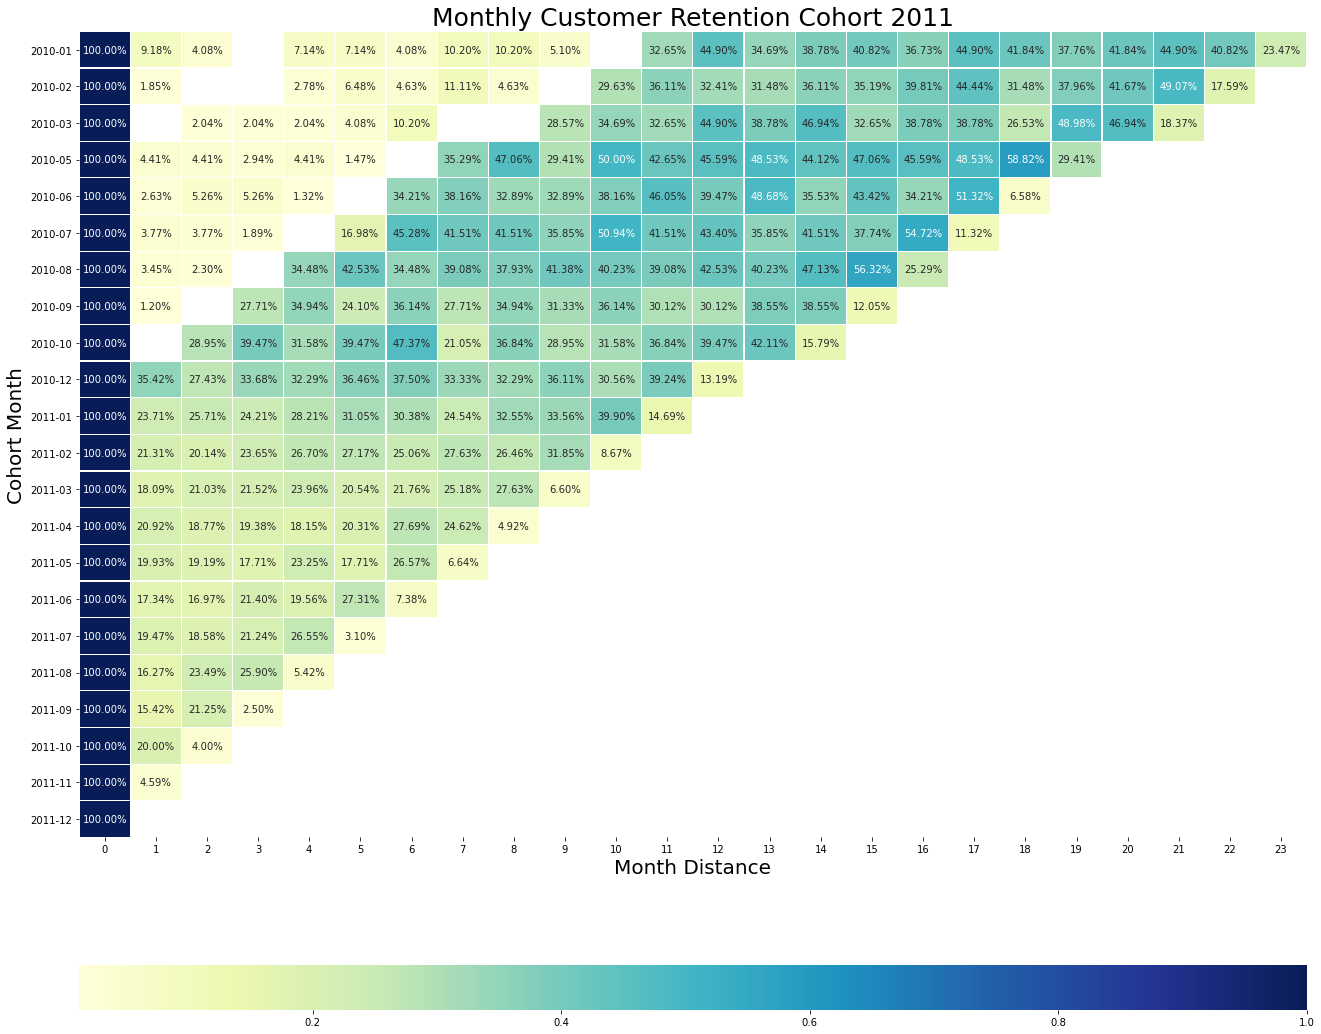

In [21]:
# Setup space of plot
grid_kws = {'height_ratios': (.9, .05), 'hspace': .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(22,18))

#Create Heatmap
ax = sns.heatmap(retention_in_percentage,
                ax=ax,
                cbar_ax=cbar_ax,
                annot=True,
                fmt = '.2%',
                linewidths=.20,
                cbar_kws={'orientation':'horizontal'},
                cmap='YlGnBu')
ax.set_title('Monthly Customer Retention Cohort 2011', fontsize=25)
ax.set_ylabel('Cohort Month', fontsize=20)
ax.set_xlabel('Month Distance', fontsize=20)
plt.show()


____
## 4. Cohort Analysis : Data Visualization Lineplot

In [22]:
df_lineplot = df_cohort.copy()
df_lineplot.head()

,cohort_month,current_order_month,n_customers,period_number
0,2010-01,2010-01,98,0
1,2010-01,2010-02,9,1
2,2010-01,2010-03,4,2
3,2010-01,2010-05,7,4
4,2010-01,2010-06,7,5


In [24]:
# Convert date to string
df_lineplot['cohort_month'] = df_lineplot['cohort_month'].astype(str)
df_lineplot['current_order_month'] = df_lineplot['current_order_month'].astype(str)

# Convert total user into percentage
df_plot_state = df_lineplot.groupby(['cohort_month']).agg({'n_customers': 'max'})
df_plot = df_lineplot.set_index(['cohort_month']).div(df_plot_state, level='cohort_month') * 100
df_plot = df_plot.reset_index()[['cohort_month', 'n_customers']].rename(columns={'n_customers': 'percentage_customers'})
df_plot.head()

# Add the early version DF
df_plot['current_order_month'] = df_lineplot['current_order_month']
df_plot['period_number'] = df_lineplot['period_number']
df_plot = df_plot[['cohort_month', 'current_order_month', 'percentage_customers', 'period_number']]
df_plot.head()


,cohort_month,current_order_month,percentage_customers,period_number
0,2010-01,2010-01,100.000000,0
1,2010-01,2010-02,9.183673,1
2,2010-01,2010-03,4.081633,2
3,2010-01,2010-05,7.142857,4
4,2010-01,2010-06,7.142857,5


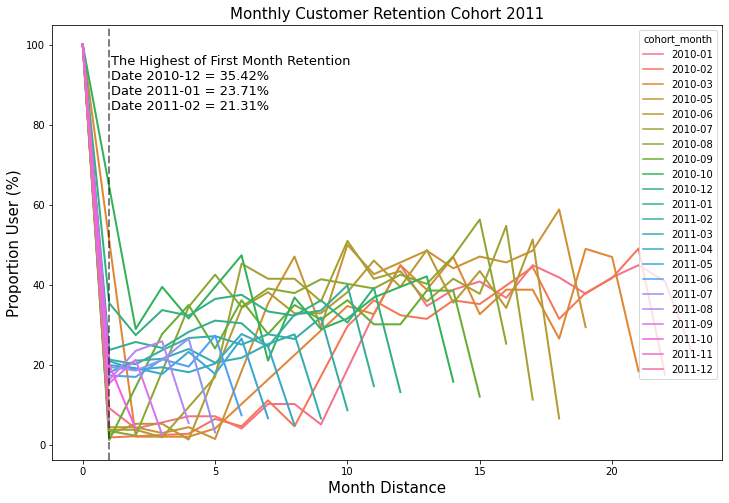

In [28]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(x='period_number',
                 y='percentage_customers',
                 hue='cohort_month',
                 dashes=True,
                 linewidth=2,
                 data=df_plot,
                 palette='husl')

ax.set_title('Monthly Customer Retention Cohort 2011', fontsize=15)
ax.set_ylabel('Proportion User (%)', fontsize=15)
ax.set_xlabel('Month Distance', fontsize=15)

# Create line to inform the best 3 of first month
top_3 = df_plot[df_plot['period_number'] == 1].sort_values('percentage_customers', ascending=False).iloc[:3]
top_3_name = top_3['cohort_month'].tolist()
top_3_value = [round(x, 2) for x in top_3['percentage_customers'].tolist()]

# String Information
text_plot = f"""
The Highest of First Month Retention
Date {top_3_name[0]} = {top_3_value[0]}%
Date {top_3_name[1]} = {top_3_value[1]}%
Date {top_3_name[2]} = {top_3_value[2]}%
"""

plt.axvline(x=1, linestyle='--', color='black', lw=2, alpha=0.5)
plt.text(1.05, 80, text_plot, fontsize=13)
plt.show()

